In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from unityagents import UnityEnvironment

from dqn_agent import DQN_AGENT

%matplotlib inline
from IPython import display
import time

In [2]:
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
def save_agent(agent, episode_count):
    checkpoint = {
        "action_size" : agent.action_size,
        "state_size"  : agent.state_size,
        "seed"        : agent.seed,
        "time_steps"  : agent.time_steps,
        "state_dict"  : agent.learning_network.state_dict(),
        "episodes"    : episode_count
    }
    filename = f"agent_{episode_count}.pth"
    torch.save(checkpoint, filename)
    return filename

In [5]:
def plot_scores(scores, mean_scores, save_fig=False, filename=None):
    plt.plot(scores, label="Score")
    plt.plot(mean_scores, label="Rolling Mean")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.legend()
    if save_fig:
        plt.savefig(filename+'.png')
    plt.show()

In [6]:
def initialize_experiences(agent, env, action_size, brain_name, size=50000):
    e_count = 0
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    
    while e_count < size:
        action = np.random.choice(np.arange(action_size))
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done, train=False)
        state = next_state
        e_count += 1
        
        if done:
            env_info = env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations[0]            

EPISODE 790 -->	Score : 15.0	Rolling Avg : 13.14	Max : 25.00	Time : 10.1 secs	 eps : 0.02


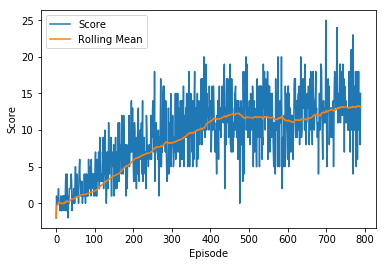

Hooray... Environment Solved in 795 episodes!! Avg. Score : 13.52
Checkpoint : agent_795.pth


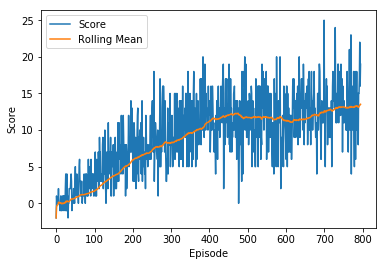

<Figure size 432x288 with 0 Axes>

In [7]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
score = 0
scores = list()
mean_scores_window = list()
scores_window = deque(maxlen=100)

env_state_size = len(state)
env_action_size = brain.vector_action_space_size

agent = DQN_AGENT(env_state_size, env_action_size, 42)
eps_start = 1.0
eps_decay = 0.995
eps_fixed = 0.01
eps = eps_start

start_time = time.time()
print("Initializing Replay Memory [50,000 Experiences]...")
initialize_experiences(agent, env, env_action_size, brain_name)
print("Finished Initializing Replay Memory ...\tTime : {:.1f} secs".format(time.time() - start_time))

start_time = time.time()

for i in range(1, 1000):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    
    while True:
        action = agent.act(state, eps)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done)
        score += reward
        state = next_state

        if done:
            scores.append(score)
            scores_window.append(score)
            mean_scores_window.append(np.mean(scores_window))
            break
        
    eps = max(eps_fixed, eps*eps_decay)
    
    if i % 10 == 0:
        display.clear_output(wait=True)
        print("EPISODE {} -->\tScore : {}\tRolling Avg : {:.2f}\tMax : {:.2f}\tTime : {:.1f} secs\t eps : {:.2f}".format(i, score, np.mean(scores_window), np.max(scores), time.time()-start_time, eps))
        plot_scores(scores, mean_scores_window)
        start_time = time.time()
        
    if np.mean(scores_window) > 13.5:
        display.clear_output(wait=True)
        print(f"Hooray... Environment Solved in {i} episodes!! Avg. Score : {np.mean(scores_window)}")
        checkpoint = save_agent(agent, i)
        print(f"Checkpoint : {checkpoint}")
        plot_scores(scores, mean_scores_window, save_fig=True, filename=checkpoint.split('.')[0])
        break
        